# 第三次作业 

## 使用真实数据

### 导入数据

In [345]:
import numpy as np
import os
from scipy.stats import norm

# 实验数据
os.chdir('/Users/chichu/学习资料/数据挖掘/Best Subset Regression')
X = np.loadtxt("./Data/x.txt", delimiter=",")
n,p = X.shape
Y = np.loadtxt("./Data/y.txt", delimiter=",")
names = np.loadtxt("./Data/names.txt", delimiter=",", dtype=str)[0:8]

### 自变量描述性统计

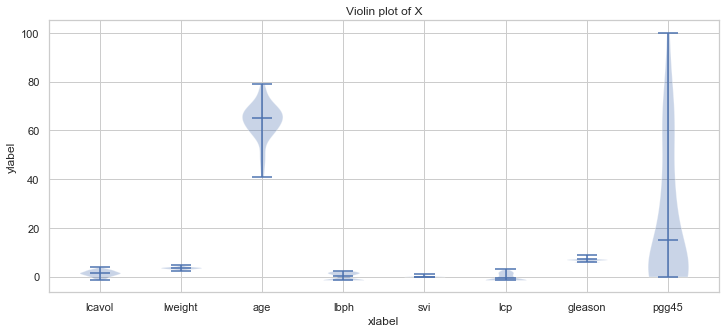

In [346]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(figsize=(12, 5))
axes.violinplot(X, showmeans=False, showmedians=True)
axes.set_title('Violin plot of X')
axes.yaxis.grid(True)
axes.set_xticks([y + 1 for y in range(p)], )
axes.set_xlabel('xlabel')
axes.set_ylabel('ylabel')
plt.setp(axes, xticks=[y + 1 for y in range(p)],
         xticklabels=names,)
plt.show()

### 主成分分析

#### 第一步、标准化

In [347]:
from sklearn.preprocessing import StandardScaler
X_scaled = StandardScaler().fit_transform(X)
Y_scaled = StandardScaler().fit_transform(Y.reshape(-1, 1))

#### 第二步、计算标准化矩阵的协方差矩阵，即原始矩阵的相关系数矩阵
- 用np.cov或np.corrcoef
 - 原始矩阵的相关系数矩阵就是标准化后矩阵的协方差矩阵
- 对X.scaled利用协方差矩阵公式

In [348]:
n,p = X.shape
X_cor = np.corrcoef(X_scaled.T)
    # 直接用np.cov求: np.cov(X_scaled.T)
    # X_cov = np.dot(X_scaled.T, X_scaled)/(n-1)
print('Covariance matrix of X_scaled: \n%s' %X_cor)

Covariance matrix of X_scaled: 
[[ 1.          0.28052139  0.22499988  0.0273497   0.538845    0.67531048
   0.43241706  0.43365225]
 [ 0.28052139  1.          0.34796911  0.44226439  0.15538491  0.16453715
   0.0568821   0.10735379]
 [ 0.22499988  0.34796911  1.          0.3501859   0.11765804  0.12766775
   0.2688916   0.27611245]
 [ 0.0273497   0.44226439  0.3501859   1.         -0.08584324 -0.00699943
   0.07782045  0.07846002]
 [ 0.538845    0.15538491  0.11765804 -0.08584324  1.          0.67311118
   0.32041222  0.45764762]
 [ 0.67531048  0.16453715  0.12766775 -0.00699943  0.67311118  1.
   0.51483006  0.63152825]
 [ 0.43241706  0.0568821   0.2688916   0.07782045  0.32041222  0.51483006
   1.          0.75190451]
 [ 0.43365225  0.10735379  0.27611245  0.07846002  0.45764762  0.63152825
   0.75190451  1.        ]]


#### 第三步、特征值与特征向量

In [349]:
eig_vals, eig_vecs = np.linalg.eigh(X_cor)
print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 0.33648701  0.17349703 -0.62501056  0.40591988  0.10063444  0.33161511
   0.05369897 -0.42224005]
 [-0.05978282 -0.01046653  0.53236051  0.43787933 -0.13182374  0.4224938
  -0.53877313 -0.18712415]
 [-0.08228769 -0.11361112 -0.05859593 -0.14212325  0.79275344 -0.24245431
  -0.46863197 -0.22322795]
 [ 0.03729392  0.08275523 -0.36257286 -0.43575621 -0.51054935 -0.08336125
  -0.62886897 -0.08562866]
 [ 0.04314492  0.46041071  0.28266015 -0.58336083  0.12037404  0.39519323
   0.20742156 -0.39020837]
 [-0.51526685 -0.6321386  -0.12396509 -0.12048346 -0.13602816  0.18687032
   0.19008256 -0.46417852]
 [-0.44086034  0.49109579  0.04920223  0.27860398 -0.15808421 -0.53818216
   0.07198888 -0.40572527]
 [ 0.64290058 -0.31189904  0.30557578 -0.03101518 -0.15934987 -0.4062745
   0.08608338 -0.44406941]]

Eigenvalues 
[0.19514862 0.26262383 0.44221301 0.48329089 0.6320111  0.97566104
 1.64830631 3.3607452 ]


##### 特征值与特征向量的对角化性质验证

In [350]:
# 施密特正交化
def schmidt_orthogonality(matrix_org, debug=False):
    """
    b1 = a1, b2 = a2 - kb1, b3 = a3 - k1b1 - k2b2
    :param matrix_org: m x n matrix, m >= n 且满秩
    :return:
    """
    m, n = matrix_org.shape
    matrix_ortho = matrix_org.copy()
    matrix_ortho = np.asarray(matrix_ortho, dtype=np.float)
    coefficient = np.zeros(shape=(m, n)) # 系数矩阵k、k1、k2
    coefficient[0, 0] = 1 # b1 = a1

    for i in range(1, n):  # 开始处理下一列
        coefficient[i, i] = 1
        for j in range(i):
            b_j = matrix_ortho[:, j]
            k_j = np.dot(b_j, matrix_org[:, i]) / np.dot(b_j, b_j)
            coefficient[j, i] = k_j
            matrix_ortho[:, i] -= k_j * b_j
	# 正交向量b1,b2...做正交化处理，系数也做相应的改变
    for i in range(n):
        devider = np.dot(matrix_ortho[:, i], matrix_ortho[:, i])
        if abs(devider) < 1e-16:  # 避免除以0
            matrix_ortho[:, i] *= 0
        else:
            devider = np.sqrt(devider)
            matrix_ortho[:, i] /= devider
            coefficient[i, :] *= devider

    return matrix_ortho

In [351]:
# 计算特征向量矩阵经过施密特正交化后的矩阵Q
Q = schmidt_orthogonality(eig_vecs)
# 通过QT.X.Q将矩阵进行对角化
X_cor_diag = Q.T.dot(X_cor).dot(Q)
X_cor_diag

array([[ 1.95148622e-01,  7.52074198e-17,  4.21893954e-16,
        -9.77671665e-18, -3.36925781e-17, -1.46052541e-18,
        -1.05837700e-16, -2.29621200e-16],
       [-1.77999550e-17,  2.62623825e-01, -4.01895097e-17,
        -2.15867927e-16, -1.94459841e-17,  9.53392246e-17,
        -1.36543175e-16,  1.31509854e-17],
       [ 3.99614321e-16, -1.39254228e-17,  4.42213013e-01,
         1.33622960e-16,  2.37511247e-16, -1.50168828e-16,
         4.46474912e-16,  1.14025999e-16],
       [ 4.34000280e-17, -1.76970736e-16,  1.55900633e-16,
         4.83290893e-01,  7.32188657e-17, -5.75922898e-17,
         2.28069969e-16,  3.59246450e-16],
       [-7.57188981e-17, -1.59743286e-17,  2.60641956e-16,
         5.62533912e-17,  6.32011096e-01,  1.89301937e-16,
         1.30852162e-16, -9.41873497e-17],
       [-1.12904648e-17, -8.94139623e-19, -1.41457843e-16,
        -3.92422296e-17,  2.38739484e-17,  9.75661041e-01,
        -1.41885502e-16,  1.69346925e-17],
       [-5.55111512e-17, -1.110223

In [352]:
# 验证：特征值=矩阵被Q对角化的结果
print(eig_vals)
print(X_cor_diag.diagonal())

[0.19514862 0.26262383 0.44221301 0.48329089 0.6320111  0.97566104
 1.64830631 3.3607452 ]
[0.19514862 0.26262383 0.44221301 0.48329089 0.6320111  0.97566104
 1.64830631 3.3607452 ]


##### 通过SVD分解的第一个元素验证

In [353]:
u,s,v = np.linalg.svd(X_scaled.T)
print('Eigenvectors \n%s' %eig_vecs)
print('\nU of SVD \n%s' %u)

Eigenvectors 
[[ 0.33648701  0.17349703 -0.62501056  0.40591988  0.10063444  0.33161511
   0.05369897 -0.42224005]
 [-0.05978282 -0.01046653  0.53236051  0.43787933 -0.13182374  0.4224938
  -0.53877313 -0.18712415]
 [-0.08228769 -0.11361112 -0.05859593 -0.14212325  0.79275344 -0.24245431
  -0.46863197 -0.22322795]
 [ 0.03729392  0.08275523 -0.36257286 -0.43575621 -0.51054935 -0.08336125
  -0.62886897 -0.08562866]
 [ 0.04314492  0.46041071  0.28266015 -0.58336083  0.12037404  0.39519323
   0.20742156 -0.39020837]
 [-0.51526685 -0.6321386  -0.12396509 -0.12048346 -0.13602816  0.18687032
   0.19008256 -0.46417852]
 [-0.44086034  0.49109579  0.04920223  0.27860398 -0.15808421 -0.53818216
   0.07198888 -0.40572527]
 [ 0.64290058 -0.31189904  0.30557578 -0.03101518 -0.15934987 -0.4062745
   0.08608338 -0.44406941]]

U of SVD 
[[-0.42224005  0.05369897 -0.33161511  0.10063444 -0.40591988  0.62501056
   0.17349703  0.33648701]
 [-0.18712415 -0.53877313 -0.4224938  -0.13182374 -0.43787933 -0.53

##### 验证标准化矩阵特征向量的范数为1

In [354]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1, np.linalg.norm(ev))
print("Everything good")

Everything good


#### 第四步、计算X的每个主成分

In [355]:
X_pca = np.dot(X_scaled, eig_vecs)
X_pca

array([[ 9.96006296e-03, -7.39645315e-02,  8.01640715e-02,
        -6.89940045e-01, -4.99201285e-01, -3.11100323e-01,
         2.09903156e+00,  2.99718105e+00],
       [-2.75023775e-01, -2.71510993e-01,  9.24995300e-01,
        -4.21674861e-01,  1.51323791e-01, -1.44801560e-01,
         8.78388304e-01,  2.66375753e+00],
       [-3.81316099e-01,  3.12991513e-02,  4.21217894e-02,
        -8.41239341e-01,  1.76606482e+00, -2.19348856e+00,
         8.44109874e-01,  1.40204950e+00],
       [-3.30041033e-01, -3.01638199e-01,  9.90772411e-01,
        -5.32124795e-01,  1.44717983e-01, -2.40631471e-01,
         9.15350796e-01,  2.75545327e+00],
       [ 1.65683106e-01, -7.73337946e-02,  1.03666072e-01,
         2.21741615e-01,  6.94406618e-01,  3.29735463e-01,
         5.62719840e-01,  1.86506875e+00],
       [-1.89354440e-01, -1.54790961e-01,  9.04488795e-01,
        -3.80692451e-01, -6.81623266e-01,  1.13489770e-02,
         1.49680222e+00,  2.96474610e+00],
       [ 1.85318350e-01,  3.627936

In [356]:
X_cor.dot(eig_vecs[:,1])

array([ 0.04556445, -0.00274876, -0.02983699,  0.0217335 ,  0.12091482,
       -0.16601466,  0.12897346, -0.08191212])

In [357]:
eig_vals[1]*(eig_vecs[:,1])

array([ 0.04556445, -0.00274876, -0.02983699,  0.0217335 ,  0.12091482,
       -0.16601466,  0.12897346, -0.08191212])

In [358]:
eig_pairs = list(zip(eig_vals,eig_vecs))
eig_pairs.sort()
eig_pairs.reverse()
eig_pairs

[(3.3607451984576997,
  array([ 0.64290058, -0.31189904,  0.30557578, -0.03101518, -0.15934987,
         -0.4062745 ,  0.08608338, -0.44406941])),
 (1.6483063120117716,
  array([-0.44086034,  0.49109579,  0.04920223,  0.27860398, -0.15808421,
         -0.53818216,  0.07198888, -0.40572527])),
 (0.975661040905152,
  array([-0.51526685, -0.6321386 , -0.12396509, -0.12048346, -0.13602816,
          0.18687032,  0.19008256, -0.46417852])),
 (0.6320110958860928,
  array([ 0.04314492,  0.46041071,  0.28266015, -0.58336083,  0.12037404,
          0.39519323,  0.20742156, -0.39020837])),
 (0.4832908926534464,
  array([ 0.03729392,  0.08275523, -0.36257286, -0.43575621, -0.51054935,
         -0.08336125, -0.62886897, -0.08562866])),
 (0.4422130128299306,
  array([-0.08228769, -0.11361112, -0.05859593, -0.14212325,  0.79275344,
         -0.24245431, -0.46863197, -0.22322795])),
 (0.26262382548550783,
  array([-0.05978282, -0.01046653,  0.53236051,  0.43787933, -0.13182374,
          0.4224938 , 

##### 根据主成分占比来判断留下的主成分个数

In [359]:
# 总特征值
tot = sum(eig_vals)
# 每一个特征值/总特征值
var_exp = [(i / tot) for i in sorted(eig_vals, reverse=True)]
# 把比值进行加总
cum_var_exp = np.cumsum(var_exp)

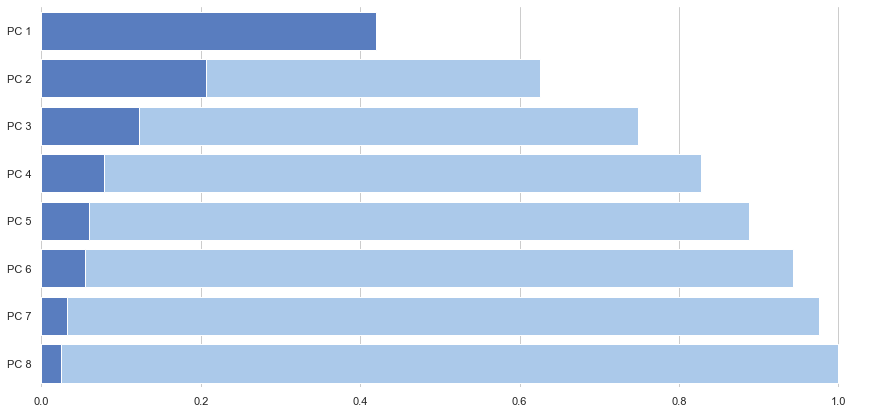

In [363]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

PC_indexes = ['PC %s' %(i+1) for i in range(p)]
f, ax = plt.subplots(figsize=(15, 7))
sns.set_color_codes("pastel")
sns.barplot(y=PC_indexes, x=cum_var_exp,color="b")
sns.set_color_codes("muted")
sns.barplot(y=PC_indexes, x=var_exp,color="b")
sns.despine(left=True, bottom=True)
plt.show()

- 从图中可看出，使用前3～4个主成分，就可以描述接近80%的方差

In [364]:
# 手动操作时，可以构造出三个主成分进行回归
PCA_X_scaled_manual = np.array([X_scaled.dot(eig_pairs[i][1]) for i in range(3)]).T

# 也可以保留所有主成分，然后用全子集回归来寻找最合适的主成分组合
PCA_X_scaled = np.array([X_scaled.dot(eig_pairs[i][1]) for i in range(p)]).T

#### 第五步、使用主成分进行全子集回归

In [365]:
os.chdir('/Users/chichu/学习资料/数据挖掘/PCAR')
import source.BestSubsetR as BSR
reg1 = BSR.BestSubsetReg(PCA_X_scaled, Y_scaled,names = PC_indexes,inter=False,isCV=False)
reg1.results()

—————Based on Cp ———————
             β
PC 1  0.182352
PC 2 -0.176886
PC 3 -0.567179
PC 7 -0.140569
PC 8  0.303308
—————————————————————————
Cp  = 0.38716596894837435
—————————————————————————

—————Based on AIC ———————
             β
PC 1  0.182352
PC 2 -0.176886
PC 3 -0.567179
PC 7 -0.140569
PC 8  0.303308
—————————————————————————
AIC  = 351.7324012963414
—————————————————————————



#### 第六步、与使用截距项的进行对比

In [366]:
reg2 = BestSubsetReg(X,Y,names,isCV = False)
reg2.results()

—————Based on Cp ———————
                  β
intercept  0.494729
lcavol     0.543998
lweight    0.588213
age       -0.016445
lbph       0.101223
svi        0.714904
—————————————————————————
Cp  = 0.5186421068394103
—————————————————————————

—————Based on AIC ———————
                  β
intercept  0.494729
lcavol     0.543998
lweight    0.588213
age       -0.016445
lbph       0.101223
svi        0.714904
—————————————————————————
AIC  = 380.0243336247493
—————————————————————————



- 结果对比中可以看出，利用主成分进行全子集回归，降低了Cp和AIC

## 使用模拟数据

生成所需函数

In [367]:
def sigma_ma(p, rho):
    if p == 1:
        return np.array([[1.0]])
    else:
        mat_left = np.power(rho, np.arange(p - 1, 0, -1)).reshape(p - 1, 1)
        mat_below = np.power(rho, np.arange(p - 1, -1, -1)).reshape(1, p)
        mat_above = np.c_[sigma_ma(p - 1, rho), mat_left]
        return np.r_[mat_above, mat_below]

def sim(n, p, rho, mu):
    var = sigma_ma(p, rho)
    uper_mat = np.linalg.cholesky(var)
    x = norm.rvs(size=(n,p))
    x = np.dot(x, uper_mat)
    x = x + mu
    return x

模拟数据

In [368]:
n = 1000
p = 10
rho = 0.75
mu = norm.rvs(size=p, scale=1)
X = sim(n, p, rho, mu) 
X_names = ["X"+str(i+1) for i in range(p)]

beta = np.ones(p) * 1
Y = np.dot(X, beta) + norm.rvs(size=n, scale=5)

主成分回归

In [372]:
import numpy as np
import os
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler


X_scaled = StandardScaler().fit_transform(X)
Y_scaled = StandardScaler().fit_transform(Y.reshape(-1, 1))
n,p = X.shape
X_cor = np.corrcoef(X_scaled.T)
eig_vals, eig_vecs = np.linalg.eigh(X_cor)

def schmidt_orthogonality(matrix_org, debug=False):
    """
    b1 = a1, b2 = a2 - kb1, b3 = a3 - k1b1 - k2b2
    :param matrix_org: m x n matrix, m >= n 且满秩
    :return:
    """
    m, n = matrix_org.shape
    matrix_ortho = matrix_org.copy()
    matrix_ortho = np.asarray(matrix_ortho, dtype=np.float)
    coefficient = np.zeros(shape=(m, n)) # 系数矩阵k、k1、k2
    coefficient[0, 0] = 1 # b1 = a1

    for i in range(1, n):  # 开始处理下一列
        coefficient[i, i] = 1
        for j in range(i):
            b_j = matrix_ortho[:, j]
            k_j = np.dot(b_j, matrix_org[:, i]) / np.dot(b_j, b_j)
            coefficient[j, i] = k_j
            matrix_ortho[:, i] -= k_j * b_j
	# 正交向量b1,b2...做正交化处理，系数也做相应的改变
    for i in range(n):
        devider = np.dot(matrix_ortho[:, i], matrix_ortho[:, i])
        if abs(devider) < 1e-16:  # 避免除以0
            matrix_ortho[:, i] *= 0
        else:
            devider = np.sqrt(devider)
            matrix_ortho[:, i] /= devider
            coefficient[i, :] *= devider

    return matrix_ortho

# 计算特征向量矩阵经过施密特正交化后的矩阵Q
Q = schmidt_orthogonality(eig_vecs)
# 通过QT.X.Q将矩阵进行对角化
X_cor_diag = Q.T.dot(X_cor).dot(Q)

X_pca = np.dot(X_scaled, eig_vecs)
eig_pairs = list(zip(eig_vals,eig_vecs))
eig_pairs.sort()
eig_pairs.reverse()

PCA_X_scaled = np.array([X_scaled.dot(eig_pairs[i][1]) for i in range(p)]).T
PC_indexes = ['PC %s' %(i+1) for i in range(p)]

os.chdir('/Users/chichu/学习资料/数据挖掘/PCAR')
from source.BestSubsetR import BestSubsetReg

print("——————1、使用PCA的全子集回归——————")
reg1 = BestSubsetReg(PCA_X_scaled, Y_scaled,inter = False, isCV = False, names = PC_indexes)
reg1.results() 

print("——————2、使用原始数据的全子集回归——————")
reg2 = BestSubsetReg(X, Y, X_names, isCV = False)
reg2.results()


——————使用PCA的全子集回归——————
—————Based on Cp ———————
             β
PC 1  0.163422
PC 2 -0.205681
PC 5 -0.209044
PC 7 -0.220634
PC 8  0.154645
PC 9  0.097689
—————————————————————————
Cp  = 0.35869620070767183
—————————————————————————

—————Based on AIC ———————
             β
PC 1  0.163422
PC 2 -0.205681
PC 5 -0.209044
PC 7 -0.220634
PC 8  0.154645
PC 9  0.097689
—————————————————————————
AIC  = 5882.498258563512
—————————————————————————

——————使用原始数据的全子集回归——————
—————Based on Cp ———————
                  β
intercept  1.003175
X1         1.241188
X2         0.691222
X3         1.318097
X4         0.672945
X5         1.497965
X6         1.079031
X8         1.654407
X9         1.162248
X10        1.150331
—————————————————————————
Cp  = 25.353489763385834
—————————————————————————

—————Based on AIC ———————
                  β
intercept  1.003175
X1         1.241188
X2         0.691222
X3         1.318097
X4         0.672945
X5         1.497965
X6         1.079031
X8         1.654407
X9  

- 结果对比结论与真实数据一致，利用主成分进行全子集回归，降低了Cp和AIC